# Requirements

##Installs

In [1]:
def check_dependencies_already_installed() -> bool:
    try:
        import gdown
        import tensorflow_addons
        return True
    except ImportError:
        return False


def install_dependencies():
    !pip install 'tensorflow==2.6.4' 'tensorflow_addons' 'tensorflow-determinism'
    !pip install --upgrade gdown


dependencies_already_installed = check_dependencies_already_installed()
print(f'dependencies_already_installed: {dependencies_already_installed}')
if not dependencies_already_installed:
    install_dependencies()

dependencies_already_installed: False
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.3/464.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB

##Imports

In [2]:
import os
import random
import json
from enum import Enum
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.data.ops.dataset_ops import Dataset
from tensorflow.python.distribute.tpu_strategy import TPUStrategy
from skimage.metrics import structural_similarity
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from datetime import datetime
from zipfile import ZipFile

# Environment setup

## Set tensorflow deterministic mode

In [3]:
def set_tf_deterministic_mode():
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    
set_tf_deterministic_mode()

## Set random seed

In [4]:
def set_training_random_seed(seed: int):
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f'set_training_random_seed() - seed value: {seed}')

## Connect to strongest available device

In [5]:
def choose_strongest_available_device_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        selected_strategy = TPUStrategy(tpu)
    except:
        selected_strategy = tf.distribute.get_strategy()

    print(f"choose_strongest_available_device_strategy() - selected strategy type: {type(selected_strategy).__name__}")

    gpu_is_available = any(tf.config.list_physical_devices('GPU'))
    if gpu_is_available:
        # show gpu info
        !nvidia-smi

    print(f'\n\n*** running_on_tpu - {isinstance(selected_strategy, TPUStrategy)} ***\n\n')
    return selected_strategy



DEVICE_STRATEGY = choose_strongest_available_device_strategy()

choose_strongest_available_device_strategy() - selected strategy type: _DefaultDistributionStrategy
Thu Feb 23 20:52:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    30W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------

##Download competition dataset

In [6]:
LOCAL_DATASET_FOLDER_PATH = Path('./train_data/gan-getting-started/')


def download_competition_dataset_if_not_present():
    dataset_already_downloaded = LOCAL_DATASET_FOLDER_PATH.exists()
    print(f"dataset_already_downloaded: {dataset_already_downloaded}")
    if not dataset_already_downloaded:
        # note - this is the untouched competition dataset. just uploaded it to the drive so it'll be
        # available via colab as well.
        !gdown '1ZwcoO11NKhYsbuM7hzdSzKjGOnOx6X94'
        !mkdir -p {LOCAL_DATASET_FOLDER_PATH}
        !unzip -o -q ./gan-getting-started.zip -d {LOCAL_DATASET_FOLDER_PATH}


download_competition_dataset_if_not_present()

dataset_already_downloaded: False
Downloading...
From: https://drive.google.com/uc?id=1ZwcoO11NKhYsbuM7hzdSzKjGOnOx6X94
To: /content/gan-getting-started.zip
100% 385M/385M [00:04<00:00, 83.0MB/s]


#Architecure 1 - Cycle Gan with Patch discriminator

## Load and normalize competition dataset

In [7]:
def find_competition_dataset_files(local_dataset_folder_path: Path):
    if isinstance(DEVICE_STRATEGY, TPUStrategy):
        from kaggle_datasets import KaggleDatasets
        dataset_folder_path = Path(KaggleDatasets().get_gcs_path())
    else:
        dataset_folder_path = local_dataset_folder_path

    monet_dataset_files = tf.io.gfile.glob(str(dataset_folder_path / 'monet_tfrec/*.tfrec'))
    photo_dataset_files = tf.io.gfile.glob(str(dataset_folder_path / 'photo_tfrec/*.tfrec'))
    assert any(monet_dataset_files)
    assert any(photo_dataset_files)
    print(f"found {len(monet_dataset_files)} monet and {len(photo_dataset_files)} photo tfrec files.")

    return monet_dataset_files, photo_dataset_files


def load_tf_records_raw_dataset(tf_record_files) -> Dataset:
    def _read_and_normalize_tfrecord(record):
        tfrecord_format = {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.string)
        }
        record = tf.io.parse_single_example(record, tfrecord_format)
        image = record['image']
        image = tf.image.decode_jpeg(image, channels=3)
        return image

    sorted_tf_record_files = sorted(tf_record_files)
    raw_dataset = tf.data.TFRecordDataset(sorted_tf_record_files)
    raw_dataset = raw_dataset.map(_read_and_normalize_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return raw_dataset


def normalize_images_dataset_for_model(images_dataset: Dataset, batch_size: int = 1) -> Dataset:
    def _prepare_image_tensor_for_training(image):
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        image = tf.reshape(image, [256, 256, 3])
        image = tf.image.resize(image, (320, 320), method='bilinear')
        return image

    images_dataset = images_dataset.map(
        _prepare_image_tensor_for_training, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(batch_size)
    return images_dataset

## Choose 30 monet train images

### Utils

In [8]:
class TrainImagesSelectionMethod(Enum):
    RandomSelection = 'random_selection'
    FarthestImagesByPixelDistance = 'farthest_images_by_pixel_distance'
    ClosestImagesByPixelDistance = 'closest_images_by_pixel_distance'
    FarthestImagesByStructuralDistance = 'farthest_images_by_structural_distance'
    ClosestImagesByStructuralDistance = 'closest_images_by_structural_distance'
    FarthestImagesByEarthMoversDistance = 'farthest_images_by_earth_movers_distance'
    ClosestImagesByEarthMoversDistance = 'closest_images_by_earth_movers_distance'


def _choose_30_monet_train_images(
        raw_ordered_monet_dataset: Dataset, method: TrainImagesSelectionMethod,
        experiment_random_seed: int, use_preprocessed_cache: bool
) -> Dataset:
    set_training_random_seed(seed=42)

    try:
        original_raw_ordered_monet_images = list(raw_ordered_monet_dataset)
        if use_preprocessed_cache:
            # because the image selection process is deterministic, and can take a while for
            # to execute, we cached its results in this dictionary. if use_preprocessed_cache is
            # set to true, this cache is utilized to reduce the runtime of the experiments.
            preprocessed_indices_cache = {
                TrainImagesSelectionMethod.RandomSelection: [203, 266, 152, 9, 233, 226, 196, 109, 5, 175, 237, 57, 218, 45, 182, 221, 289, 211, 148, 165, 78, 113, 249, 250, 104, 42, 281, 295, 157, 238],
                TrainImagesSelectionMethod.FarthestImagesByPixelDistance: [57, 299, 113, 74, 160, 193, 139, 283, 93, 56, 90, 196, 108, 34, 45, 40, 249, 87, 240, 106, 218, 208, 2, 289, 16, 11, 155, 52, 292, 272],
                TrainImagesSelectionMethod.ClosestImagesByPixelDistance: [57, 119, 185, 203, 70, 216, 238, 61, 273, 169, 81, 222, 68, 137, 58, 67, 295, 164, 50, 217, 179, 190, 125, 290, 44, 251, 274, 195, 7, 165],
                TrainImagesSelectionMethod.FarthestImagesByStructuralDistance: [57, 134, 16, 152, 133, 116, 94, 147, 177, 161, 40, 9, 218, 110, 70, 101, 75, 54, 243, 100, 98, 237, 77, 115, 106, 119, 45, 261, 241, 90],
                TrainImagesSelectionMethod.ClosestImagesByStructuralDistance: [57, 254, 238, 160, 86, 295, 187, 51, 41, 81, 273, 120, 230, 148, 25, 13, 264, 114, 236, 155, 58, 59, 151, 91, 107, 207, 289, 203, 176, 125],
                TrainImagesSelectionMethod.FarthestImagesByEarthMoversDistance: [57, 168, 144, 249, 145, 117, 288, 109, 48, 207, 252, 251, 186, 278, 296, 39, 263, 234, 167, 165, 128, 41, 290, 176, 33, 107, 202, 201, 282, 127],
                TrainImagesSelectionMethod.ClosestImagesByEarthMoversDistance: [57, 196, 13, 131, 148, 97, 187, 74, 11, 162, 147, 240, 55, 70, 102, 76, 213, 139, 256, 253, 247, 17, 227, 108, 86, 133, 19, 77, 42, 1],
            }
            assert method in preprocessed_indices_cache, f"unknown method - '{method}'"
            chosen_30_images_indices = preprocessed_indices_cache[method]
        elif method is TrainImagesSelectionMethod.RandomSelection:
            chosen_30_images_indices = _pick_random_images(
                original_raw_ordered_monet_images, images_count=30
            )
        elif method is TrainImagesSelectionMethod.FarthestImagesByPixelDistance:
            chosen_30_images_indices = _pick_images_farthest_from_each_other(
                original_raw_ordered_monet_images,
                distance_func=_images_pixel_distance,
                images_count=30
            )
        elif method is TrainImagesSelectionMethod.ClosestImagesByPixelDistance:
            chosen_30_images_indices = _pick_images_farthest_from_each_other(
                original_raw_ordered_monet_images,
                distance_func=_images_pixel_distance,
                images_count=30,
                reverse_distance=True
            )
        elif method is TrainImagesSelectionMethod.FarthestImagesByStructuralDistance:
            chosen_30_images_indices = _pick_images_farthest_from_each_other(
                original_raw_ordered_monet_images,
                distance_func=_images_structural_distance,
                images_count=30
            )
        elif method is TrainImagesSelectionMethod.ClosestImagesByStructuralDistance:
            chosen_30_images_indices = _pick_images_farthest_from_each_other(
                original_raw_ordered_monet_images,
                distance_func=_images_structural_distance,
                images_count=30,
                reverse_distance=True
            )
        elif method is TrainImagesSelectionMethod.FarthestImagesByEarthMoversDistance:
            chosen_30_images_indices = _pick_images_farthest_from_each_other(
                original_raw_ordered_monet_images,
                distance_func=_earth_movers_distance,
                images_count=30
            )
        elif method is TrainImagesSelectionMethod.ClosestImagesByEarthMoversDistance:
            chosen_30_images_indices = _pick_images_farthest_from_each_other(
                original_raw_ordered_monet_images,
                distance_func=_earth_movers_distance,
                images_count=30,
                reverse_distance=True
            )
        else:
            raise NotImplementedError(f"unknown method - '{method}'")

        chosen_30_raw_images_dataset = Dataset.from_tensor_slices([
            original_raw_ordered_monet_images[image_idx]
            for image_idx in chosen_30_images_indices
        ])
        _plot_chosen_30_images(chosen_30_raw_images_dataset)
    finally:
        set_training_random_seed(experiment_random_seed)
    return chosen_30_raw_images_dataset


def _plot_chosen_30_images(chosen_30_raw_images_dataset):
    try:
        images_shape = list(chosen_30_raw_images_dataset)[0].shape
        print(f'*** Selected 30 train monet photos (shape: {images_shape}) ***')
        _, ax = plt.subplots(30, 1, figsize=(50, 50))
        for i, img in enumerate(chosen_30_raw_images_dataset):
            # img = (img * 127.5 + 127.5).numpy()[0].astype(np.uint8)
            ax[i].imshow(img)
        plt.show()
    finally:
        plt.close()

### Pick images strategies

This is based on the image distance methods implementation in [this](https://gist.github.com/duhaime/211365edaddf7ff89c0a36d9f3f7956c) post

In [9]:
def _pick_images_farthest_from_each_other(
        original_ordered_monet_images: list, distance_func, images_count: int, reverse_distance: bool = False
) -> list:
    comparison_images_resize_shape = (100, 100)

    def _pre_comparison_transformation_func(image_tensor):
        image_array = image_tensor.numpy()
        resized_image = tf.image.resize(image_array, comparison_images_resize_shape).numpy()
        resized_image = resized_image
        return resized_image

    final_distance_func = distance_func
    if reverse_distance:
        final_distance_func = lambda image1, image2: -distance_func(image1, image2)

    chosen_30_images_indices = _incremental_farthest_search(
        original_ordered_monet_images,
        k=images_count,
        distance_func=final_distance_func,
        pre_comparison_transformation_func=_pre_comparison_transformation_func
    )
    return chosen_30_images_indices


def _incremental_farthest_search(
        ordered_image_tensors_list, k: int, distance_func, pre_comparison_transformation_func
):
    remaining_images = [
        dict(
            orig_image_index=orig_image_index,
            img_tensor=img_tensor,
            img_comparison_array=pre_comparison_transformation_func(img_tensor)
        )
        for orig_image_index, img_tensor in enumerate(ordered_image_tensors_list)
    ]

    chosen_30_images_indices = [remaining_images.pop(random.randint(0, len(remaining_images) - 1))]
    for _ in tqdm(list(range(k - 1)), desc='incremental_farthest_search() main loop'):
        distances = [
            distance_func(
                i['img_comparison_array'],
                chosen_30_images_indices[0]['img_comparison_array']
            )
            for i in remaining_images
        ]
        for i, p in enumerate(remaining_images):
            for j, s in enumerate(chosen_30_images_indices):
                distances[i] = min(distances[i], distance_func(
                    p['img_comparison_array'], s['img_comparison_array']
                ))
        chosen_30_images_indices.append(remaining_images.pop(distances.index(max(distances))))
    chosen_30_images_indices = [i['orig_image_index'] for i in chosen_30_images_indices]
    return chosen_30_images_indices


def _pick_random_images(original_ordered_monet_images: list, images_count: int) -> list:
    chosen_30_images_indices = list(np.random.choice(
        list(range(len(original_ordered_monet_images))), size=images_count, replace=False
    ))
    return chosen_30_images_indices


def _images_pixel_distance(image1: np.array, image2: np.array) -> float:
    distance = np.sum((image1.flatten() - image2.flatten()) ** 2)
    return distance


def _images_structural_distance(image1: np.array, image2: np.array) -> float:
    similarity_index, *_ = structural_similarity(image1.flatten(), image2.flatten(), full=True)
    return -similarity_index


def _earth_movers_distance(image1: np.array, image2: np.array) -> float:
    image1_hist = _calc_image_greyscale_histogram(image1)
    image2_hist = _calc_image_greyscale_histogram(image2)
    distance = wasserstein_distance(image1_hist, image2_hist)
    return distance


def _calc_image_greyscale_histogram(image: np.array) -> np.array:
    greyscale_image = np.array(Image.fromarray(image).convert('L'))
    h, w = greyscale_image.shape
    hist = [0.0] * 256
    for i in range(h):
        for j in range(w):
            hist[greyscale_image[i, j]] += 1
    return np.array(hist) / (h * w)

## Cycle gan model implementation (with patch discriminator)

### Architecture definitions

In [10]:
class GeneratorNetworkStructure(Enum):
    Baseline = 'baseline'
    Thin = 'thin'
    Wide = 'wide'
    Deep = 'deep'


class DiscriminatorNetworkStructure(Enum):
    Baseline = 'baseline'
    ThinNetwork = 'thin_network'
    WideNetwork = 'wide_network'
    ThinReceptiveField = 'thin_receptive_field'
    WideReceptiveField = 'wide_receptive_field'

### Utils

In [11]:
def _down_sample_layer(filters, size, strides=2, padding='same'):
    initializer = tf.random_normal_initializer(0., 0.02)

    network = keras.Sequential()
    network.add(layers.Conv2D(filters, size, strides=strides, padding=padding,
                              kernel_initializer=initializer, use_bias=False))

    network.add(layers.LeakyReLU())

    return network


def _up_sample_layer(filters, size, strides=2, padding='same', apply_dropout=False):
    network = keras.Sequential()
    network.add(layers.Conv2DTranspose(
        filters, size, strides=strides, padding=padding, use_bias=False,
        kernel_initializer=tf.random_normal_initializer(0., 0.02)
    ))
    if apply_dropout:
        network.add(layers.Dropout(0.5))
    network.add(layers.ReLU())
    return network

### Build generator model

In [12]:
def build_generator_model(generator_network_structure: GeneratorNetworkStructure):
    down_stack, up_stack = _build_generator_encoder_decoder_layout(generator_network_structure)
    inputs = layers.Input(shape=[320, 320, 3])

    layers_to_direct_to_previous = []
    x = inputs
    for down in down_stack:
        x = down(x)
        layers_to_direct_to_previous.append(x)

    for up, skip in zip(up_stack, reversed(layers_to_direct_to_previous[:-1])):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last_layer = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    generator_model = keras.Model(inputs=inputs, outputs=last_layer(x))
    return generator_model


def _build_generator_encoder_decoder_layout(network_structure: GeneratorNetworkStructure):
    if network_structure is GeneratorNetworkStructure.Baseline:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4),
            _up_sample_layer(256, 4),
            _up_sample_layer(128, 4),
            _up_sample_layer(64, 4),
        ]
    elif network_structure is GeneratorNetworkStructure.Thin:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(512, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(256, 4, apply_dropout=True),
            _up_sample_layer(256, 4),
            _up_sample_layer(128, 4),
            _up_sample_layer(128, 4),
            _up_sample_layer(64, 4),
        ]
    elif network_structure is GeneratorNetworkStructure.Wide:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(1_024, 4),
            _down_sample_layer(1_024, 4),
            _down_sample_layer(1_024, 4),
            _down_sample_layer(1_024, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(1_024, 4, apply_dropout=True),
            _up_sample_layer(1_024, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(1_024, 4, apply_dropout=True),
            _up_sample_layer(1_024, 4),
            _up_sample_layer(512, 4),
            _up_sample_layer(256, 4),
            _up_sample_layer(64, 4),
        ]
    elif network_structure is GeneratorNetworkStructure.Deep:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(128, 4, strides=1, padding='same'),
            _down_sample_layer(256, 4),
            _down_sample_layer(256, 4, strides=1, padding='same'),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='same'),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='same'),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='same'),
            _up_sample_layer(512, 4),
            _up_sample_layer(512, 4, strides=1, padding='same'),
            _up_sample_layer(256, 4),
            _up_sample_layer(256, 4, strides=1, padding='same'),
            _up_sample_layer(128, 4),
            _up_sample_layer(128, 4, strides=1, padding='same'),
            _up_sample_layer(64, 4),
        ]
    else:
        raise NotImplementedError(f"unknown network structure - '{network_structure}'")
    return down_stack, up_stack

### Build patch discriminator model

In [13]:
def build_discriminator_model(discriminator_network_structure: DiscriminatorNetworkStructure):
    inp = layers.Input(shape=[320, 320, 3], name='input_image')
    conv_layers_layout = _build_patch_discriminator_conv_layers_layout(discriminator_network_structure)
    x = inp
    for down_conv in conv_layers_layout:
        x = down_conv(x)

    zero_pad1 = layers.ZeroPadding2D()(x)
    initializer = tf.random_normal_initializer(0.0, 0.02)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    leaky_relu = layers.LeakyReLU()(conv)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    discriminator_model = tf.keras.Model(inputs=inp, outputs=last)
    return discriminator_model


def _build_patch_discriminator_conv_layers_layout(network_structure: DiscriminatorNetworkStructure):
    if network_structure is DiscriminatorNetworkStructure.Baseline:
        # final receptive filed size = 123
        conv_layers_layout = [
            _down_sample_layer(64, 5),
            _down_sample_layer(128, 4),
            _down_sample_layer(256, 3),
            _down_sample_layer(256, 2),
        ]
    elif network_structure is DiscriminatorNetworkStructure.ThinNetwork:
        # final receptive filed size = 123
        conv_layers_layout = [
            _down_sample_layer(32, 5),
            _down_sample_layer(64, 4),
            _down_sample_layer(128, 3),
            _down_sample_layer(256, 2),
        ]
    elif network_structure is DiscriminatorNetworkStructure.WideNetwork:
        # final receptive filed size = 123
        conv_layers_layout = [
            _down_sample_layer(128, 5),
            _down_sample_layer(256, 4),
            _down_sample_layer(512, 3),
            _down_sample_layer(256, 2),
        ]
    elif network_structure is DiscriminatorNetworkStructure.ThinReceptiveField:
        # final receptive filed size = 47
        conv_layers_layout = [
            _down_sample_layer(64, size=3, strides=2),
            _down_sample_layer(128, size=3, strides=2),
            _down_sample_layer(256, size=3, strides=1),
            _down_sample_layer(256, size=3, strides=1),
        ]
    elif network_structure is DiscriminatorNetworkStructure.WideReceptiveField:
        # final receptive filed size = 310
        conv_layers_layout = [
            _down_sample_layer(64, size=4, strides=3),
            _down_sample_layer(128, size=4, strides=3),
            _down_sample_layer(256, size=4, strides=2),
            _down_sample_layer(256, size=4, strides=2),
        ]
    else:
        raise NotImplementedError(f"unknown network structure - '{network_structure}'")
    return conv_layers_layout

### Build cycle gan model

In [14]:
class CycleGanModel(keras.Model):
    def __init__(
            self,
            monet_generator,
            photo_generator,
            monet_discriminator,
            photo_discriminator,
            lambda_cycle,
    ):
        super(CycleGanModel, self).__init__()
        self._monet_generator = monet_generator
        self._photo_generator = photo_generator
        self._monet_discriminator = monet_discriminator
        self._photo_discriminator = photo_discriminator
        self._lambda_cycle = lambda_cycle

    def compile(
            self,
            m_gen_optimizer,
            p_gen_optimizer,
            m_disc_optimizer,
            p_disc_optimizer,
            gen_loss_fn,
            disc_loss_fn,
            cycle_loss_fn,
            identity_loss_fn
    ):
        super(CycleGanModel, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        monet_img, photo_img = batch_data

        with tf.GradientTape(persistent=True) as tape:
            monet_disc_loss, photo_disc_loss, monet_gen_loss, photo_gen_loss = \
                self._calc_internal_models_losses(monet_img, photo_img)
        self._apply_internal_models_gradients(
            monet_disc_loss, photo_disc_loss, photo_gen_loss, monet_gen_loss, tape
        )
        ret_losses = {
            "monet_gen_loss": monet_gen_loss,
            "photo_gen_loss": photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
        return ret_losses

    def store_models(self, storage_folder_path: Path):
        assert storage_folder_path.exists(), \
            f"expected the output folder to exist on the disk - '{storage_folder_path}'"

        self._monet_generator.save_weights(storage_folder_path / 'monet_generator.ckpt')
        self._photo_generator.save_weights(storage_folder_path / 'photo_generator.ckpt')
        self._monet_discriminator.save_weights(storage_folder_path / 'monet_discriminator.ckpt')
        self._photo_discriminator.save_weights(storage_folder_path / 'photo_discriminator.ckpt')

    def _calc_internal_models_losses(self, real_monet, real_photo):
        fake_monet = self._monet_generator(real_photo, training=True)
        cycled_photo = self._photo_generator(fake_monet, training=True)

        fake_photo = self._photo_generator(real_monet, training=True)
        cycled_monet = self._monet_generator(fake_photo, training=True)

        same_monet = self._monet_generator(real_monet, training=True)
        same_photo = self._photo_generator(real_photo, training=True)

        disc_real_monet = self._monet_discriminator(real_monet, training=True)
        disc_real_photo = self._photo_discriminator(real_photo, training=True)

        disc_fake_monet = self._monet_discriminator(fake_monet, training=True)
        disc_fake_photo = self._photo_discriminator(fake_photo, training=True)

        monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
        photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

        total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self._lambda_cycle) + \
                           self.cycle_loss_fn(real_photo, cycled_photo, self._lambda_cycle)

        final_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                               self.identity_loss_fn(real_monet, same_monet, self._lambda_cycle)
        final_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
                               self.identity_loss_fn(real_photo, same_photo, self._lambda_cycle)

        final_monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
        final_photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        return final_monet_disc_loss, final_photo_disc_loss, final_monet_gen_loss, final_photo_gen_loss

    def _apply_internal_models_gradients(
            self, monet_disc_loss, photo_disc_loss, photo_gen_loss, monet_gen_loss, tape
    ):
        monet_generator_gradients = tape.gradient(monet_gen_loss, self._monet_generator.trainable_variables)
        photo_generator_gradients = tape.gradient(photo_gen_loss, self._photo_generator.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self._monet_discriminator.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self._photo_discriminator.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self._monet_generator.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self._photo_generator.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self._monet_discriminator.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self._photo_discriminator.trainable_variables))


def _build_losses():
    def identity_loss(real_image, same_image, lambda_):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_ * 0.5 * loss

    def generators_loss(generated):
        loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(generated), generated)
        return loss

    def discriminators_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def final_cycle_loss(real_image, cycled_image, lambda_):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return lambda_ * loss1

    return identity_loss, generators_loss, discriminators_loss, final_cycle_loss


def construct_cycle_gan_model(train_settings):
    generator_network_structure = train_settings['generator_network_structure']
    discriminator_network_structure = train_settings['discriminator_network_structure']
    monet_generator = build_generator_model(generator_network_structure)
    photo_generator = build_generator_model(generator_network_structure)
    monet_discriminator = build_discriminator_model(discriminator_network_structure)
    photo_discriminator = build_discriminator_model(discriminator_network_structure)

    identity_loss, generators_loss, discriminators_loss, final_cycle_loss = _build_losses()

    optimizer_builder = train_settings['optimizer_builder']
    monet_generator_optimizer = optimizer_builder()
    photo_generator_optimizer = optimizer_builder()
    monet_discriminator_optimizer = optimizer_builder()
    photo_discriminator_optimizer = optimizer_builder()

    cycle_gan_model = CycleGanModel(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10
    )
    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=generators_loss,
        disc_loss_fn=discriminators_loss,
        cycle_loss_fn=final_cycle_loss,
        identity_loss_fn=identity_loss
    )
    return cycle_gan_model, monet_generator

## Train images augmentations

In [15]:
def add_random_augmentations(
        raw_images_dataset: Dataset, random_seed: int, usage_each_image_n_times: int
) -> Dataset:
    augmentations_pipe = keras.Sequential([
        layers.RandomFlip(
            'horizontal_and_vertical', seed=random_seed
        ),
        layers.RandomZoom(
            height_factor=(0, -0.15), width_factor=(0, -0.15), seed=random_seed
        ),
        layers.RandomRotation(
            0.3, seed=random_seed
        )
    ])
    images_dataset_with_augmentations = raw_images_dataset.map(
        augmentations_pipe, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).repeat(usage_each_image_n_times)
    return images_dataset_with_augmentations

## Plotting utils

In [16]:
def plot_cycle_gan_train_losses(train_history):
    epoch_level_train_history = {
        loss_name: {
            epoch: epoch_losses.flatten().mean()
            for epoch, epoch_losses in enumerate(epochs_losses)
        }
        for loss_name, epochs_losses in train_history.history.items()
    }

    try:
        fig, (top_ax, bottom_ax) = plt.subplots(2, figsize=(12, 12))
        fig.suptitle('Loss vs Epoch')

        top_ax.set_title('Generators')
        plt_lines = []
        for loss_name in ('monet_gen_loss', 'photo_gen_loss'):
            loss_epoch_values = epoch_level_train_history[loss_name]
            line, = top_ax.plot(loss_epoch_values.keys(), loss_epoch_values.values(), label=loss_name)
            plt_lines.append(line)
        top_ax.legend(handles=plt_lines)

        bottom_ax.set_title('Discriminators')
        plt_lines = []
        for loss_name in ('monet_disc_loss', 'photo_disc_loss'):
            loss_epoch_values = epoch_level_train_history[loss_name]
            line, = bottom_ax.plot(loss_epoch_values.keys(), loss_epoch_values.values(), label=loss_name)
            plt_lines.append(line)
        bottom_ax.legend(handles=plt_lines)

        plt.tight_layout()
        plt.show()
    finally:
        plt.close()

    final_losses = {
        loss_name: str(loss_epoch_values[max(loss_epoch_values.keys())])
        for loss_name, loss_epoch_values in epoch_level_train_history.items()
    }
    print(f"*** trained cycle gan final losses ***\n{json.dumps(final_losses, indent=4)}")


def plot_predictions_sample(monet_generator, photo_dataset):
    print('*** Show trained model predictions sample ***')
    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i, img in enumerate(photo_dataset.take(5)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

## Kaggle competition submission utils

In [17]:
def create_predictions_for_kaggle_submission(monet_generator: tf.keras.Model, photo_dataset: Dataset):
    wip_images_folder = Path(f"/tmp/wip_{datetime.now().strftime('%y_%m_%d__%H_%M_%S')}/")
    wip_images_folder.mkdir(parents=True, exist_ok=True)
    output_zip_path = Path('/kaggle/working/images.zip')
    if output_zip_path.exists():
        output_zip_path.unlink()

    with ZipFile(output_zip_path, 'w') as output_images_zip, \
            tqdm(total=7_038, desc='generating prediction images for kaggle submission') as pbar:
        for i, img in enumerate(photo_dataset):
            prediction = monet_generator(img, training=False)[0]
            prediction = tf.image.resize(prediction, (256, 256), method='bilinear')
            prediction = prediction.numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            im = Image.fromarray(prediction)
            wip_image_file_path = wip_images_folder / f'{i + 1}.jpg'
            im.save(wip_image_file_path)
            output_images_zip.write(filename=wip_image_file_path, arcname=wip_image_file_path.name)
            wip_image_file_path.unlink()
            pbar.update()

## Cycle gan experiment full train + kaggle submission flow

In [18]:
#Cycle gan experiment full train + kaggle submission flow
def cycle_gan_experiment_flow(
        choose_30_images_method: TrainImagesSelectionMethod,
        train_settings: dict,
        experiment_random_seed: int,
        create_kaggle_predictions_for_submission: bool = False,
):
    set_training_random_seed(experiment_random_seed)

    monet_dataset_files, photo_dataset_files = find_competition_dataset_files(LOCAL_DATASET_FOLDER_PATH)
    train_raw_ordered_monet_dataset = load_tf_records_raw_dataset(monet_dataset_files)
    train_raw_photo_dataset = load_tf_records_raw_dataset(photo_dataset_files)

    train_selected_raw_monet_dataset = _choose_30_monet_train_images(
        train_raw_ordered_monet_dataset, choose_30_images_method,
        experiment_random_seed, use_preprocessed_cache=True
    )

    train_selected_raw_monet_dataset, train_raw_photo_dataset = _handle_experiment_augmentations(
        train_settings['augmentation_settings'], experiment_random_seed,
        train_selected_raw_monet_dataset, train_raw_photo_dataset
    )

    train_selected_monet_dataset = normalize_images_dataset_for_model(train_selected_raw_monet_dataset)
    train_photo_dataset = normalize_images_dataset_for_model(train_raw_photo_dataset)

    train_pairs_dataset = tf.data.Dataset.zip((train_selected_monet_dataset, train_photo_dataset))

    with DEVICE_STRATEGY.scope():
        cycle_gan_model, monet_generator = construct_cycle_gan_model(train_settings)

    train_history = cycle_gan_model.fit(
        train_pairs_dataset,
        epochs=train_settings['train_epochs'],
        verbose=2
    )
    plot_cycle_gan_train_losses(train_history)

    inference_raw_photo_dataset = load_tf_records_raw_dataset(photo_dataset_files)
    inference_photo_dataset = normalize_images_dataset_for_model(inference_raw_photo_dataset)
    plot_predictions_sample(monet_generator, inference_photo_dataset)

    _store_experiment_model(
        cycle_gan_model, choose_30_images_method=choose_30_images_method,
        train_settings=train_settings, experiment_random_seed=experiment_random_seed
    )
    if create_kaggle_predictions_for_submission:
        create_predictions_for_kaggle_submission(monet_generator, inference_photo_dataset)


def _handle_experiment_augmentations(
        augmentation_settings: dict, experiment_random_seed: int,
        train_selected_raw_monet_dataset: Dataset, train_raw_photo_dataset: Dataset
):
    if augmentation_settings['monet_dataset']['enabled']:
        train_selected_raw_monet_dataset = add_random_augmentations(
            train_selected_raw_monet_dataset, experiment_random_seed,
            usage_each_image_n_times=augmentation_settings['monet_dataset'].get('usage_each_image_n_times', 1)
        )

    if augmentation_settings['photo_dataset']['enabled']:
        train_raw_photo_dataset = add_random_augmentations(
            train_raw_photo_dataset, experiment_random_seed,
            usage_each_image_n_times=augmentation_settings['photo_dataset'].get('usage_each_image_n_times', 1)
        )

    return train_selected_raw_monet_dataset, train_raw_photo_dataset


def _store_experiment_model(model: CycleGanModel, **experiment_settings):
    now_time_str = datetime.now().strftime('%y_%m_%d__%H_%M_%S')
    experiment_output_folder = Path(f'./experiment_outputs/{now_time_str}')
    experiment_output_folder.mkdir(parents=True, exist_ok=True)
    
    with open(experiment_output_folder / 'experiment_settings.txt', 'w') as experiment_settings_file:
        experiment_settings_file.write(str(experiment_settings))
    model.store_models(experiment_output_folder)


## Experiments execution

### Register experiments to run

In [19]:
class ExperimentsToRunConfig:
    CHOOSE_30_TRAIN_IMAGES_EXPERIMENT = True
    GENERATOR_NETWORK_STRUCTURE_EXPERIMENT = True
    DISCRIMINATOR_NETWORK_STRUCTURE_EXPERIMENT = True
    TRAIN_IMAGES_AUGEMNTATION_EXPERIMENT = True
    ITAY_TO_DELETE_EXPERIMENT = False

### Experiments functions

In [20]:
def run_choose_30_train_images_experiment():
    base_desc = 'choose_30_images_methods loop'
    with tqdm(total=len(TrainImagesSelectionMethod), desc=base_desc) as pbar:
        for method in TrainImagesSelectionMethod:
            pbar.set_description(f"{base_desc} (curr_method = '{method}')")
            cycle_gan_experiment_flow(
                choose_30_images_method=method,
                train_settings=dict(
                    train_epochs=40,
                    optimizer_builder=lambda: tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001),
                    generator_network_structure=GeneratorNetworkStructure.Baseline,
                    discriminator_network_structure=DiscriminatorNetworkStructure.Baseline,
                    augmentation_settings=dict(
                        monet_dataset=dict(enabled=False),
                        photo_dataset=dict(enabled=False),
                    )
                ),
                experiment_random_seed=1,
                create_kaggle_predictions_for_submission=False
            )
            pbar.update()


def run_generator_network_structure_experiment():
    base_desc = 'generator_network_structure_experiment loop'
    with tqdm(total=len(GeneratorNetworkStructure), desc=base_desc) as pbar:
        for generator_network_structure in GeneratorNetworkStructure:
            pbar.set_description(f"{base_desc} (generator_network_structure={generator_network_structure})")
            cycle_gan_experiment_flow(
                choose_30_images_method=TrainImagesSelectionMethod.FarthestImagesByPixelDistance,
                train_settings=dict(
                    train_epochs=40,
                    optimizer_builder=lambda: tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001),
                    generator_network_structure=generator_network_structure,
                    discriminator_network_structure=DiscriminatorNetworkStructure.Baseline,
                    augmentation_settings=dict(
                        monet_dataset=dict(enabled=False),
                        photo_dataset=dict(enabled=False),
                    )
                ),
                experiment_random_seed=1,
                create_kaggle_predictions_for_submission=False
            )
            pbar.update()


def run_discriminator_network_structure_experiment():
    base_desc = 'run_discriminator_network_structure_experiment loop'
    with tqdm(total=len(DiscriminatorNetworkStructure), desc=base_desc) as pbar:
        for discriminator_network_structure in DiscriminatorNetworkStructure:
            pbar.set_description(f"{base_desc} (discriminator_network_structure={discriminator_network_structure})")
            cycle_gan_experiment_flow(
                choose_30_images_method=TrainImagesSelectionMethod.FarthestImagesByPixelDistance,
                train_settings=dict(
                    train_epochs=40,
                    optimizer_builder=lambda: tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001),
                    generator_network_structure=GeneratorNetworkStructure.Thin,
                    discriminator_network_structure=discriminator_network_structure,
                    augmentation_settings=dict(
                        monet_dataset=dict(enabled=False),
                        photo_dataset=dict(enabled=False),
                    )
                ),
                experiment_random_seed=1,
                create_kaggle_predictions_for_submission=False
            )
            pbar.update()


def run_train_images_augemntation_experiment():
    experiment_augmentation_settings_list = [
        dict(
            monet_dataset=dict(enabled=False),
            photo_dataset=dict(enabled=False),
        ),
        dict(
            monet_dataset=dict(
                enabled=True,
                usage_each_image_n_times=10
            ),
            photo_dataset=dict(
                enabled=False,
                usage_each_image_n_times=1
            ),
        ),
        dict(
            monet_dataset=dict(
                enabled=False,
                usage_each_image_n_times=10
            ),
            photo_dataset=dict(
                enabled=True,
                usage_each_image_n_times=1
            ),
        ),
        dict(
            monet_dataset=dict(
                enabled=True,
                usage_each_image_n_times=10
            ),
            photo_dataset=dict(
                enabled=True,
                usage_each_image_n_times=1
            ),
        ),
        dict(
            monet_dataset=dict(
                enabled=True,
                usage_each_image_n_times=20
            ),
            photo_dataset=dict(
                enabled=True,
                usage_each_image_n_times=1
            ),
        ),
    ]

    base_desc = 'run_train_images_augemntation_experiment loop'
    with tqdm(total=len(experiment_augmentation_settings_list), desc=base_desc) as pbar:
        for augmentation_settings in experiment_augmentation_settings_list:
            pbar.set_description(f"{base_desc} (augmentation_settings={augmentation_settings})")
            cycle_gan_experiment_flow(
                choose_30_images_method=TrainImagesSelectionMethod.FarthestImagesByPixelDistance,
                train_settings=dict(
                    train_epochs=40,
                    optimizer_builder=lambda: tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001),
                    generator_network_structure=GeneratorNetworkStructure.Thin,
                    discriminator_network_structure=DiscriminatorNetworkStructure.Baseline,
                    augmentation_settings=augmentation_settings
                ),
                experiment_random_seed=1,
                create_kaggle_predictions_for_submission=True
            )
            pbar.update()


# todo itay - delete
def run_itay_to_delete_experiment():
    cycle_gan_experiment_flow(
        choose_30_images_method=TrainImagesSelectionMethod.FarthestImagesByPixelDistance,
        train_settings=dict(
            train_epochs=40,
            optimizer_builder=lambda: tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.001),
            generator_network_structure=GeneratorNetworkStructure.Thin,
            discriminator_network_structure=DiscriminatorNetworkStructure.Baseline,
            augmentation_settings=dict(
                monet_dataset=dict(
                    enabled=False,
                    usage_each_image_n_times=20
                ),
                photo_dataset=dict(
                    enabled=False,
                    usage_each_image_n_times=1
                ),
            )
        ),
        experiment_random_seed=1,
        create_kaggle_predictions_for_submission=False
    )

### Run registered experiments

In [21]:
# todo itay - delete
curr_version = 18
print(f'*** curr_version: {curr_version} ***')

*** curr_version: 18 ***


choose_30_images_methods loop (curr_method = 'TrainImagesSelectionMethod.RandomSelection'):   0%|          | 0/7 [00:00<?, ?it/s]

set_training_random_seed() - seed value: 1
found 5 monet and 20 photo tfrec files.
set_training_random_seed() - seed value: 42
*** Selected 30 train monet photos (shape: (256, 256, 3)) ***


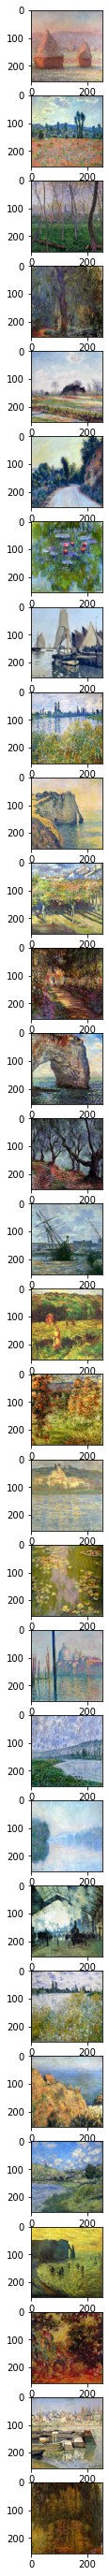

set_training_random_seed() - seed value: 1
Epoch 1/40
30/30 - 40s - monet_gen_loss: 7.6893 - photo_gen_loss: 5.4553 - monet_disc_loss: 0.0800 - photo_disc_loss: 0.6551
Epoch 2/40
30/30 - 18s - monet_gen_loss: 4.3750 - photo_gen_loss: 4.2587 - monet_disc_loss: 0.7378 - photo_disc_loss: 0.7789
Epoch 3/40
30/30 - 18s - monet_gen_loss: 4.1833 - photo_gen_loss: 3.4065 - monet_disc_loss: 0.7022 - photo_disc_loss: 0.9684
Epoch 4/40
30/30 - 19s - monet_gen_loss: 3.6349 - photo_gen_loss: 3.0829 - monet_disc_loss: 0.7568 - photo_disc_loss: 0.7029
Epoch 5/40
30/30 - 19s - monet_gen_loss: 3.2631 - photo_gen_loss: 2.7904 - monet_disc_loss: 0.9043 - photo_disc_loss: 0.7664
Epoch 6/40
30/30 - 19s - monet_gen_loss: 3.1267 - photo_gen_loss: 2.5883 - monet_disc_loss: 0.6787 - photo_disc_loss: 0.8354
Epoch 7/40


In [ ]:
if ExperimentsToRunConfig.CHOOSE_30_TRAIN_IMAGES_EXPERIMENT:
    run_choose_30_train_images_experiment()

In [ ]:
if ExperimentsToRunConfig.GENERATOR_NETWORK_STRUCTURE_EXPERIMENT:
    run_generator_network_structure_experiment()

In [ ]:
if ExperimentsToRunConfig.DISCRIMINATOR_NETWORK_STRUCTURE_EXPERIMENT:
    run_discriminator_network_structure_experiment()

In [ ]:
if ExperimentsToRunConfig.TRAIN_IMAGES_AUGEMNTATION_EXPERIMENT:
    run_train_images_augemntation_experiment()

In [ ]:
if ExperimentsToRunConfig.ITAY_TO_DELETE_EXPERIMENT:
    run_itay_to_delete_experiment()